In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,RepeatVector
from keras.layers import Dropout
from keras.layers import Flatten,Input
from keras import backend as K
from keras.models import Model, load_model
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from scipy.spatial import distance
from sklearn.decomposition import PCA
from numpy import linalg as LA
from keras.objectives import categorical_crossentropy
from sklearn.metrics import roc_curve, auc
import math
from scipy.stats import pearsonr
import copy
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import itertools
import csv
from sklearn import metrics
import tensorflow as tf
import tensorflow.contrib.layers as tl
import numpy as np
import pandas as pd 
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
import seaborn as sb
%matplotlib inline


/home/ramchalamkr/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Denoising Autoencoders

## Type 1 - using tensorflow + keras

### Load Data

In [55]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()
# all the pixel values normalised between 0 and 1. Then we can use a classification method for reconstruction loss.
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
# reshaped to 784 (28x28), to be used with only fully connected neural nets
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

### normal autoencoders without denoising

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_7 (Dense)              (None, 784)               101136    
Total para

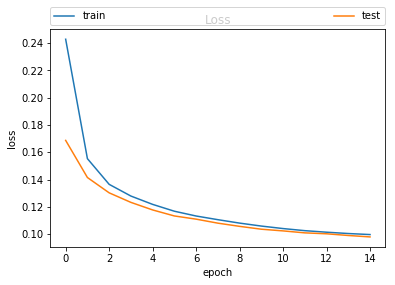

In [33]:
InputWidth = x_train.shape[1]
K.clear_session()
model = Sequential()
#model.add(Input(shape =(784,)))
model.add(Dense(128, input_shape = (784,), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(784, activation='sigmoid'))
print model.summary()
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
op = model.fit(x_train, x_train, validation_data=(x_test, x_test), epochs=15, batch_size=256, verbose=2).history
# Loss Curve
plt.plot(op['loss'],label ='train')
plt.plot(op['val_loss'],label ='test')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

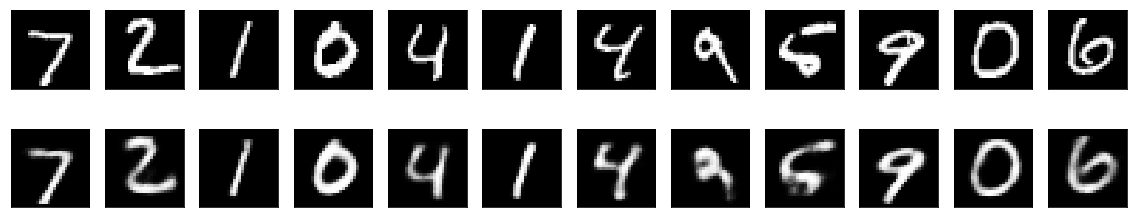

In [6]:
reconstructed_image = model.predict(x_test)
import matplotlib.pyplot as plt

n = 12   # Number of digits to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_image[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Denoising autoencoders

In [56]:
# Create the noisy data with the addition of random normal distribution.
x_train_noisy = x_train + 0.5 * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + 0.5 * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
print x_train_noisy.shape
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

(60000, 784)


Train on 60000 samples, validate on 10000 samples
Epoch 1/15
3s - loss: 0.1227 - acc: 0.8102 - val_loss: 0.1236 - val_acc: 0.8096
Epoch 2/15
3s - loss: 0.1222 - acc: 0.8102 - val_loss: 0.1227 - val_acc: 0.8092
Epoch 3/15
3s - loss: 0.1218 - acc: 0.8103 - val_loss: 0.1224 - val_acc: 0.8094
Epoch 4/15
3s - loss: 0.1212 - acc: 0.8104 - val_loss: 0.1223 - val_acc: 0.8096
Epoch 5/15
3s - loss: 0.1208 - acc: 0.8104 - val_loss: 0.1218 - val_acc: 0.8088
Epoch 6/15
3s - loss: 0.1205 - acc: 0.8105 - val_loss: 0.1216 - val_acc: 0.8091
Epoch 7/15
3s - loss: 0.1200 - acc: 0.8105 - val_loss: 0.1209 - val_acc: 0.8094
Epoch 8/15
3s - loss: 0.1198 - acc: 0.8106 - val_loss: 0.1211 - val_acc: 0.8097
Epoch 9/15
3s - loss: 0.1195 - acc: 0.8106 - val_loss: 0.1220 - val_acc: 0.8079
Epoch 10/15
3s - loss: 0.1192 - acc: 0.8106 - val_loss: 0.1210 - val_acc: 0.8101
Epoch 11/15
3s - loss: 0.1188 - acc: 0.8107 - val_loss: 0.1210 - val_acc: 0.8097
Epoch 12/15
3s - loss: 0.1185 - acc: 0.8108 - val_loss: 0.1207 - val

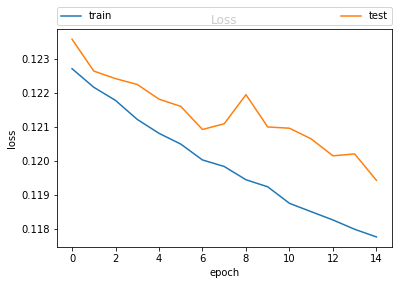

In [11]:
# Use the same model defined previously to fit the noisy data.
op = model.fit(x_train_noisy, x_train, validation_data=(x_test_noisy, x_test), epochs=15, batch_size=256, verbose=2).history
plt.plot(op['loss'],label ='train')
plt.plot(op['val_loss'],label ='test')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

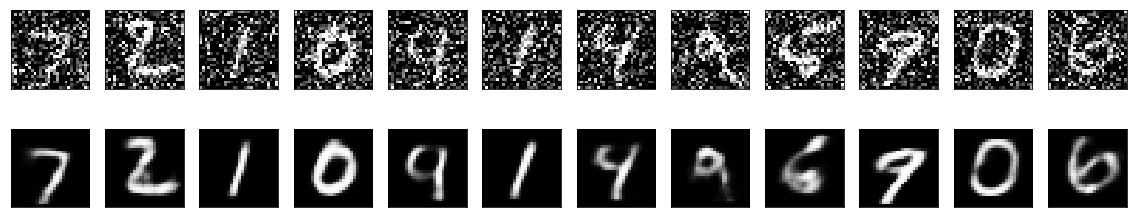

In [12]:
reconstructed_image = model.predict(x_test_noisy)
import matplotlib.pyplot as plt

n = 12   # Number of digits to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_image[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Anti Autoencoder

#### Used a function (first used 1-every pixel value - This would mean blacks and whites would get swapped)
#### To make it even more dissimilar, used (1-pixelvalue)*pixelvalue - Also called a chaotic cipher.  This will result in more randomness in the image. For ease of understanding and visualisation, we have used the first case.

In [57]:

import copy
x_train_swapped = (1-copy.deepcopy(x_train))
x_test_swapped = (1-copy.deepcopy(x_test))
#x_train_noisy_swapped = (1-copy.deepcopy(x_train_noisy))*copy.deepcopy(x_train_noisy)
#x_test_noisy_swapped = (1-copy.deepcopy(x_test_noisy))*copy.deepcopy(x_test_noisy)

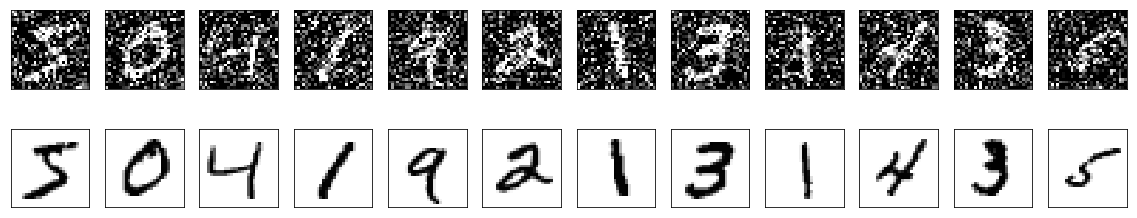

In [58]:
import matplotlib.pyplot as plt

n = 12  # Number of digits to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display noisy with pixels swapped
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display dissimilar image to the above image. 
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_train_swapped[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
4s - loss: 0.1267 - acc: 0.8095 - val_loss: 0.1268 - val_acc: 0.8079
Epoch 2/15
4s - loss: 0.1256 - acc: 0.8097 - val_loss: 0.1261 - val_acc: 0.8082
Epoch 3/15
4s - loss: 0.1246 - acc: 0.8098 - val_loss: 0.1249 - val_acc: 0.8085
Epoch 4/15
4s - loss: 0.1238 - acc: 0.8099 - val_loss: 0.1243 - val_acc: 0.8089
Epoch 5/15
4s - loss: 0.1231 - acc: 0.8100 - val_loss: 0.1238 - val_acc: 0.8091
Epoch 6/15
4s - loss: 0.1224 - acc: 0.8101 - val_loss: 0.1232 - val_acc: 0.8087
Epoch 7/15
4s - loss: 0.1217 - acc: 0.8102 - val_loss: 0.1223 - val_acc: 0.8092
Epoch 8/15
4s - loss: 0.1211 - acc: 0.8103 - val_loss: 0.1219 - val_acc: 0.8096
Epoch 9/15
4s - loss: 0.1207 - acc: 0.8104 - val_loss: 0.1222 - val_acc: 0.8099
Epoch 10/15
4s - loss: 0.1202 - acc: 0.8104 - val_loss: 0.1212 - val_acc: 0.8091
Epoch 11/15
4s - loss: 0.1198 - acc: 0.8105 - val_loss: 0.1220 - val_acc: 0.8097
Epoch 12/15
4s - loss: 0.1194 - acc: 0.8105 - val_loss: 0.1208 - val

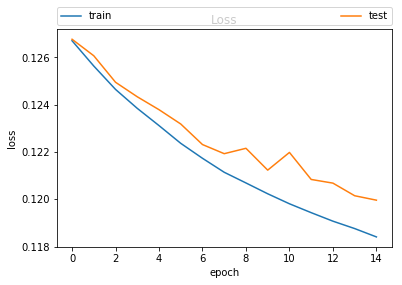

In [62]:
op = model.fit(x_train_noisy,x_train_swapped, validation_data=(x_test_noisy,x_test_swapped), epochs=15, batch_size=128, verbose=2).history
plt.plot(op['loss'],label ='train')
plt.plot(op['val_loss'],label ='test')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

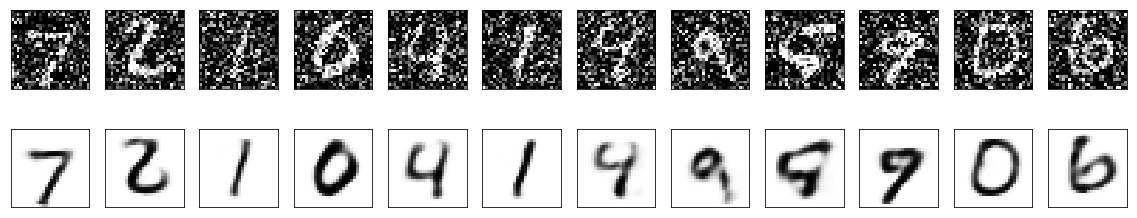

In [63]:
reconstructed_image = model.predict(x_test_noisy)
import matplotlib.pyplot as plt

n = 12  # Number of digits to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_image[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Everybody Freeze - Transfer Learning

#### First train the autoencoder, and save the model. In the second iteration, using a similar architecture, freeze the encoder layers and retrain the decoder layer after loading the saved weights from the first model. This is essentially used to ensure that the original data is not further used. Whatever be the input given, titll only use the encoded layer output as input to the decoder. So it helps in data compression, also in data privacy and not having to share the original data.

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
4s - loss: 0.2745 - acc: 0.7862 - val_loss: 0.2224 - val_acc: 0.7950
Epoch 2/15
3s - loss: 0.1970 - acc: 0.7975 - val_loss: 0.1782 - val_acc: 0.7993
Epoch 3/15
3s - loss: 0.1713 - acc: 0.8015 - val_loss: 0.1645 - val_acc: 0.8003
Epoch 4/15
3s - loss: 0.1617 - acc: 0.8033 - val_loss: 0.1572 - val_acc: 0.8022
Epoch 5/15
4s - loss: 0.1558 - acc: 0.8044 - val_loss: 0.1529 - val_acc: 0.8043
Epoch 6/15
4s - loss: 0.1517 - acc: 0.8051 - val_loss: 0.1504 - val_acc: 0.8047
Epoch 7/15
3s - loss: 0.1486 - acc: 0.8057 - val_loss: 0.1469 - val_acc: 0.8035
Epoch 8/15
3s - loss: 0.1457 - acc: 0.8062 - val_loss: 0.1442 - val_acc: 0.8051
Epoch 9/15
4s - loss: 0.1430 - acc: 0.8067 - val_loss: 0.1416 - val_acc: 0.8050
Epoch 10/15
4s - loss: 0.1406 - acc: 0.8071 - val_loss: 0.1396 - val_acc: 0.8070
Epoch 11/15
3s - loss: 0.1389 - acc: 0.8074 - val_loss: 0.1381 - val_acc: 0.8055
Epoch 12/15
3s - loss: 0.1373 - acc: 0.8077 - val_loss: 0.1366 - val

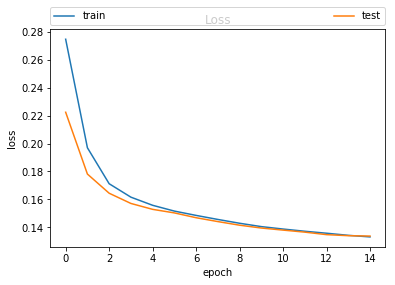

In [17]:
InputWidth = x_train.shape[1]
K.clear_session()
inp = Input(shape =(784,),name = 'inp')
# Encoder
x = Dense(128, activation='relu',name = 'd1')(inp) #12x12
x = Dense(64, activation='relu',name = 'd2')(x)
encoder = Dense(32, activation='relu',name = 'd3')(x)

#Decoder
x = Dense(32, activation='relu',name = 'd4')(encoder)
x = Dense(64, activation='relu',name = 'd5')(x)
x = Dense(128, activation='relu',name = 'd6')(x)
decoder = Dense(InputWidth, activation='sigmoid',name = 'd7')(x)

ae = Model(inp,decoder)
ae.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
op = ae.fit(x_train_noisy, x_train, validation_data=(x_test_noisy, x_test), epochs=15, batch_size=256, verbose=2).history

# Save model weights
ae.save_weights('ae_FNN.h5')
plt.plot(op['loss'],label ='train')
plt.plot(op['val_loss'],label ='test')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
3s - loss: 0.2266 - acc: 0.7888 - val_loss: 0.1629 - val_acc: 0.8028
Epoch 2/20
3s - loss: 0.1543 - acc: 0.8053 - val_loss: 0.1474 - val_acc: 0.8048
Epoch 3/20
3s - loss: 0.1449 - acc: 0.8067 - val_loss: 0.1424 - val_acc: 0.8049
Epoch 4/20
3s - loss: 0.1409 - acc: 0.8073 - val_loss: 0.1396 - val_acc: 0.8069
Epoch 5/20
3s - loss: 0.1388 - acc: 0.8077 - val_loss: 0.1380 - val_acc: 0.8071
Epoch 6/20
3s - loss: 0.1374 - acc: 0.8079 - val_loss: 0.1370 - val_acc: 0.8072
Epoch 7/20
3s - loss: 0.1361 - acc: 0.8081 - val_loss: 0.1359 - val_acc: 0.8071
Epoch 8/20
3s - loss: 0.1351 - acc: 0.8082 - val_loss: 0.1354 - val_acc: 0.8063
Epoch 9/20
3s - loss: 0.1342 - acc: 0.8084 - val_loss: 0.1344 - val_acc: 0.8074
Epoch 10/20
3s - loss: 0.1334 - acc: 0.8085 - val_loss: 0.1334 - val_acc: 0.8072
Epoch 11/20
3s - loss: 0.1328 - acc: 0.8086 - val_loss: 0.1328 - val_acc: 0.8074
Epoch 12/20
3s - loss: 0.1323 - acc: 0.8086 - val_loss: 0.1324 - val

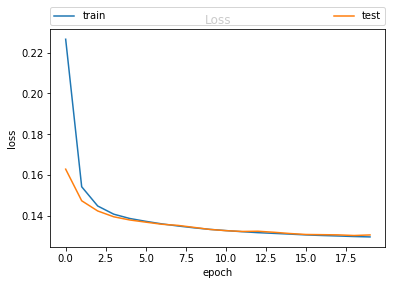

In [19]:
inp1 = Input(shape =(784,),name = 'inp')
# The encoder network is not being trained. The weights to these layers are fixed

#Encoder
x1 = Dense(128, activation='relu',trainable = False,name = 'd1')(inp1) #12x12
x1 = Dense(64, activation='relu',trainable = False,name = 'd2')(x1)
encoder1 = Dense(32, activation='relu',trainable = False,name = 'd3')(x1)

#Decoder
x1 = Dense(32, activation='relu',name='d4new')(encoder1)
x1 = Dense(64, activation='relu',name='d5new')(x1)
x1 = Dense(128, activation='relu',name='d6new')(x1)
decoder1 = Dense(InputWidth, activation='sigmoid',name='d7new')(x1)
aeNew = Model(inp1,decoder1)

# Load the weights only for the encoder and retrain the decoder only.
aeNew.load_weights('ae_FNN.h5', by_name=True)
aeNew.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
op = aeNew.fit(x_train_noisy, x_train, validation_data=(x_test_noisy, x_test), epochs=20, batch_size=256, verbose=2).history
plt.plot(op['loss'],label ='train')
plt.plot(op['val_loss'],label ='test')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

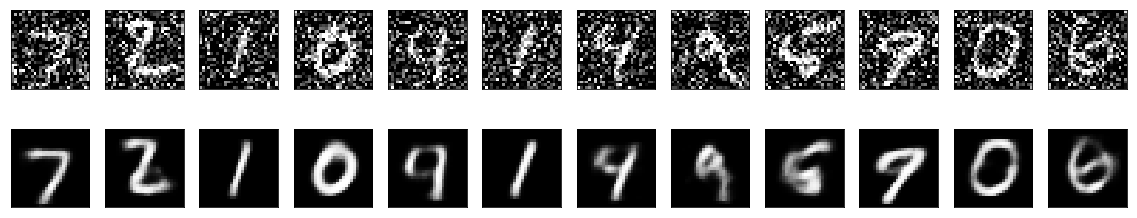

In [20]:
reconstructed_image = aeNew.predict(x_test_noisy)
import matplotlib.pyplot as plt

n = 12  # Number of digits to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_image[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Attempt to do the same using Convnets (Unable to do deep networks due to lack of hardware)

In [46]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# all the pixel values normalised between 0 and 1. Then we can use a classification method for reconstruction loss.
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
# reshaped to 784 (28x28), to be used with only fully connected neural nets
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) 
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)) 

x_train_noisy = x_train + 0.5 * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + 0.5 * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp (InputLayer)             (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 8)         0         
__________

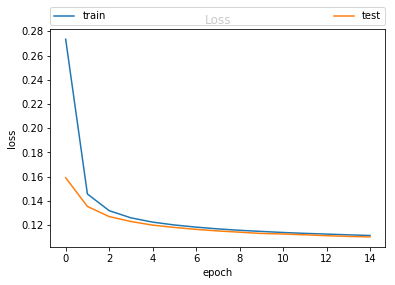

In [23]:
#InputWidth = x_train.shape[1]
K.clear_session()
inp = Input(shape =(28,28,1),name = 'inp')
# Conv2d - number of filters, filter size, activation function - outputshape = (N-F)/stride+1
# Padding is kept same so that we can recover the original dimension even after pooling and conv2d layers.
x = Conv2D(16, (3, 3), activation='relu',padding='same')(inp) #12x12
x = MaxPooling2D((2, 2),padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu',padding='same')(x)
encoder = MaxPooling2D((2, 2),padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu',padding='same')(encoder)
x = UpSampling2D((2,2))(x)
x = Conv2D(16, (3, 3), activation='relu',padding='same')(x)
x = UpSampling2D((2,2))(x)
decoder = Conv2D(1, (3, 3), activation='sigmoid',padding='same')(x)
ae = Model(inp,decoder)
print ae.summary()
ae.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
op = ae.fit(x_train_noisy, x_train, validation_data=(x_test_noisy, x_test), epochs=15, batch_size=256, verbose=2).history
plt.plot(op['loss'],label ='train')
plt.plot(op['val_loss'],label ='test')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

### Anti Autoencoder

#### Here we try a different approach. We swap the pixels of the noisy data and not the perfect data and use this for training. This makes the training a little bit difficult. However with sufficiently deep network with better hardware would provide better results 

In [48]:
x_train_noisy_swapped = (1-copy.deepcopy(x_train_noisy))
x_test_noisy_swapped = (1-copy.deepcopy(x_test_noisy))
#x_train_noisy_swapped = (1-copy.deepcopy(x_train_noisy))*copy.deepcopy(x_train_noisy)
#x_test_noisy_swapped = (1-copy.deepcopy(x_test_noisy))*copy.deepcopy(x_test_noisy)

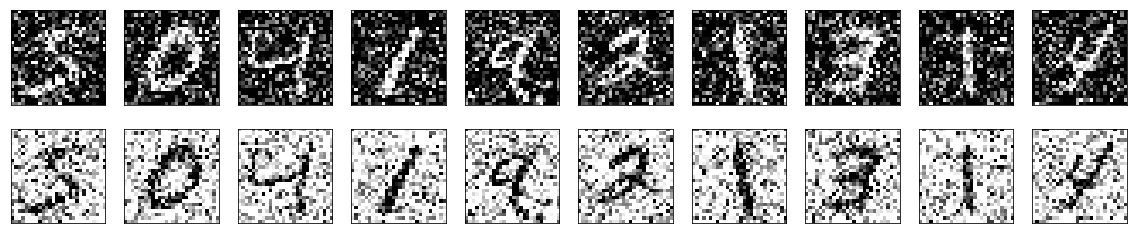

In [49]:
#reconstructed_image = model.predict(x_test_noisy)
import matplotlib.pyplot as plt

n = 10  # Number of digits to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_train_noisy_swapped[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
30s - loss: 0.5462 - acc: 0.4508 - val_loss: 0.5132 - val_acc: 0.4687
Epoch 2/15
29s - loss: 0.5078 - acc: 0.4702 - val_loss: 0.5029 - val_acc: 0.4722
Epoch 3/15
29s - loss: 0.5004 - acc: 0.4726 - val_loss: 0.4972 - val_acc: 0.4737
Epoch 4/15
29s - loss: 0.4960 - acc: 0.4738 - val_loss: 0.4941 - val_acc: 0.4746
Epoch 5/15
28s - loss: 0.4934 - acc: 0.4745 - val_loss: 0.4919 - val_acc: 0.4753
Epoch 6/15
29s - loss: 0.4911 - acc: 0.4750 - val_loss: 0.4898 - val_acc: 0.4758
Epoch 7/15
29s - loss: 0.4889 - acc: 0.4755 - val_loss: 0.4875 - val_acc: 0.4762
Epoch 8/15
29s - loss: 0.4868 - acc: 0.4759 - val_loss: 0.4854 - val_acc: 0.4766
Epoch 9/15
29s - loss: 0.4847 - acc: 0.4762 - val_loss: 0.4832 - val_acc: 0.4768
Epoch 10/15
30s - loss: 0.4826 - acc: 0.4765 - val_loss: 0.4811 - val_acc: 0.4771
Epoch 11/15
29s - loss: 0.4806 - acc: 0.4768 - val_loss: 0.4792 - val_acc: 0.4773
Epoch 12/15
29s - loss: 0.4787 - acc: 0.4771 - val_loss: 

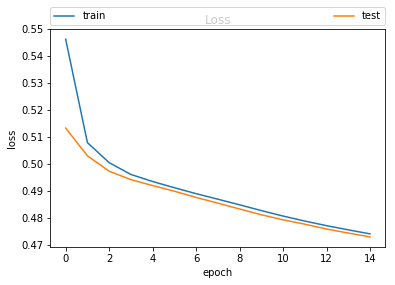

In [50]:
op = ae.fit(x_train_noisy, x_train_noisy_swapped, validation_data=(x_test_noisy, x_test_noisy_swapped), epochs=15, batch_size=256, verbose=2).history
plt.plot(op['loss'],label ='train')
plt.plot(op['val_loss'],label ='test')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

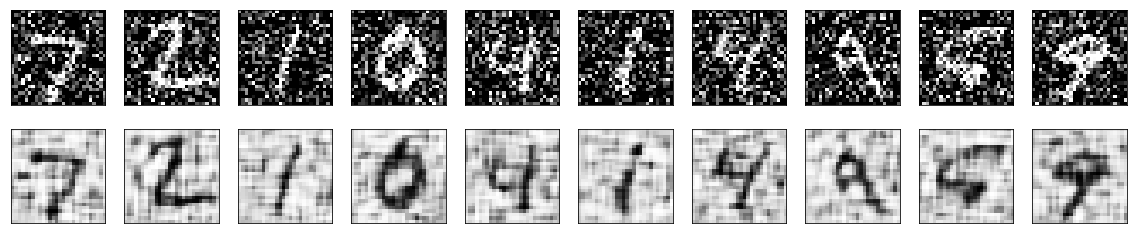

In [51]:
reconstructed_image = ae.predict(x_test_noisy)
import matplotlib.pyplot as plt

n = 10  # Number of digits to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_image[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Implementing the same for sequence data using LSTM - Seq to seq autoencoder

#### Generate the sequential data usign random numbers of dimension 200 and timesteps 1. Normalise it between 0 and 1 for LSTM to work correctly.

In [64]:
import random
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
X =[]
Xunormalised =[]
for i in range(1000):
    if(i%1000==0):
        print i
    start = random.randint(1,1000)
    stop = start + 1200
    step = 6
    temp = [j for j in range(start, stop, step)]
    series = Series(temp)
    values = series.values
    values = values.reshape((len(values), 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(values)
    temp = scaler.transform(values)
    temp2 = scaler.inverse_transform(temp)
    X.append(temp)
    Xunormalised.append(temp2)

X = np.asarray(X)
print X.shape
#X = X / X.max(axis=0)
#X = normalize(X.reshape(X.shape[0],-1), norm='max', axis=0).reshape(X.shape)
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler(feature_range=(0, 1))
#X = scaler.fit_transform(X)
X = np.reshape(X,(X.shape[0],1,X.shape[1]))
x_train,x_test = train_test_split(X,test_size = 0.3,random_state=42)
x_train_noisy = copy.deepcopy(x_train)
x_train_noisy[x_train_noisy<0.01] = 0
x_test_noisy = copy.deepcopy(x_test)
x_test_noisy[x_test_noisy<0.01] = 0
#print x_train_noisy.shape
#print x_test_noisy.shape
#print x_train_noisy[0]


0


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


(1000, 200, 1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp (InputLayer)             (None, 1, 200)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               120400    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 200)            240800    
Total params: 361,200
Trainable params: 361,200
Non-trainable params: 0
_________________________________________________________________
None
Train on 700 samples, validate on 300 samples
Epoch 1/12
0s - loss: 0.3026 - mean_squared_error: 0.3026 - val_loss: 0.2434 - val_mean_squared_error: 0.2434
Epoch 2/12
0s - loss: 0.1711 - mean_squared_error: 0.1711 - val_loss: 0.0891 - val_mean_squared_error: 0.08

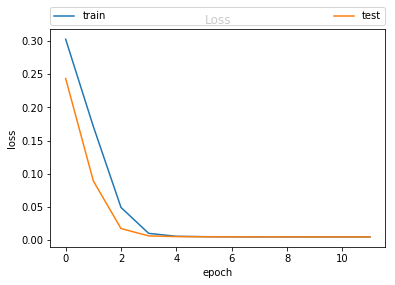

In [65]:
#InputWidth = x_train.shape[1]
K.clear_session()
timesteps = 1
inputdimension = 200
inp = Input(shape =(timesteps,inputdimension),name = 'inp')
# Conv2d - number of filters, filter size, activation function - outputshape = (N-F)/stride+1
encoder = LSTM(100)(inp)
x = RepeatVector(timesteps)(encoder)
decoder = LSTM(inputdimension,return_sequences=True)(x)
ae = Model(inp,decoder)
print ae.summary()
ae.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
op = ae.fit(x_train, x_train, validation_data=(x_test, x_test), epochs=12, batch_size=64, verbose=2).history
plt.plot(op['loss'],label ='train')
plt.plot(op['val_loss'],label ='test')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [66]:
trainPredict = ae.predict(x_train_noisy)
testPredict = ae.predict(x_test_noisy)
trainPredict = np.reshape(trainPredict,(trainPredict.shape[0],trainPredict.shape[2]))
testPredict = np.reshape(testPredict,(testPredict.shape[0],testPredict.shape[2]))
x_train_noisy = np.reshape(x_train_noisy,(x_train_noisy.shape[0],x_train_noisy.shape[2]))
x_test_noisy = np.reshape(x_test_noisy,(x_test_noisy.shape[0],x_test_noisy.shape[2]))
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[2]))
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[2]))
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
ActualTrain = scaler.inverse_transform(x_train_noisy)
testPredict = scaler.inverse_transform(testPredict)
ActualTest = scaler.inverse_transform(x_test_noisy)
# check only the first sequence to see how the prediction performs
print "Prediction",testPredict[1]
print "Noisy",ActualTest[1]
print "Without noise",scaler.inverse_transform(x_test)[1]

Prediction [ 328.01028  333.9855   339.9997   345.99377  351.99423  358.01215
  364.05978  369.97208  376.03677  382.04953  387.9369   394.10037
  400.14618  405.9742   411.9271   417.90155  423.86505  429.78235
  435.81827  441.86362  448.21356  454.14258  459.75818  465.67947
  471.75168  478.02582  483.6999   490.08224  495.705    501.9631
  508.3956   513.82574  520.30493  525.6517   531.98145  538.4135
  543.75323  550.3287   556.38776  561.48236  567.5569   573.6772
  580.30554  585.50793  592.1944   598.38763  604.0174   610.03143
  615.4519   621.5885   627.91364  633.99725  639.477    645.5064
  652.4845   657.9439   663.76227  669.47095  675.3751   681.5669
  687.45575  694.2522   699.4922   706.4926   711.57275  717.7604
  723.85736  730.10266  735.6817   742.66315  748.7598   754.64954
  760.0471   765.48755  771.8721   778.399    784.52936  790.19836
  795.49756  802.3979   808.05054  814.729    820.5955   826.5174
  832.67535  838.5944   844.713    850.39777  856.774    8

### Anti AutoEncoder

#### In this technique, to make the output as dissimilar to the input, we train the input sequence to the reverse of the sequence meaning: 1,2,3,4,5 is trained with 5,4,3,2,1. Here the input and output are maximally dissimalr. In addtion, the output could also be a scaled up version and various other modifications can be done. For ease and the current time constraints, we have only used the first approach. 

In [77]:
import random
from pandas import Series
import numpy as np
from sklearn.preprocessing import MinMaxScaler
X =[]
Xreversed =[]
for i in range(1000):
    start = random.randint(1,1000)
    stop = start + 1200
    step = 6
    temp = [j for j in range(start, stop, step)]
    series = Series(temp)
    values = series.values
    values = values.reshape((len(values), 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(values)
    temp = scaler.transform(values)
    X.append(temp)
    Xreversed.append(temp[::-1])
    
#print X[0]
#print Xreversed[0]
X = np.asarray(X)
Xreversed = np.asarray(Xreversed)
#print X.shape
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler(feature_range=(0, 1))
#X = scaler.fit_transform(X)
X = np.reshape(X,(X.shape[0],1,X.shape[1]))
#Xreversed = scaler.fit_transform(Xreversed)
Xreversed = np.reshape(Xreversed,(Xreversed.shape[0],1,Xreversed.shape[1]))
x_train,x_test = train_test_split(X,test_size = 0.3,random_state=42)
x_train_noisy,x_test_noisy =  train_test_split(Xreversed,test_size = 0.3,random_state=42)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp (InputLayer)             (None, 1, 200)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 150)               210600    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 150)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 75)                67800     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 1, 75)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 200)            220800    
Total params: 499,200
Trainable params: 499,200
Non-trainable params: 0
_________________________________________________________________
None

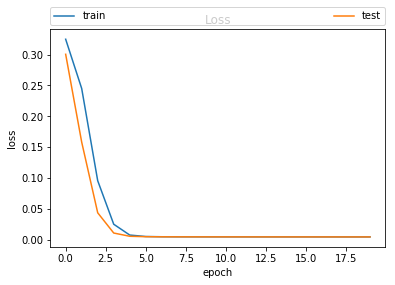

In [78]:
#InputWidth = x_train.shape[1]
K.clear_session()
timesteps = 1
inputdimension = 200
inp = Input(shape =(timesteps,inputdimension),name = 'inp')
encoder = LSTM(150)(inp)
x = RepeatVector(timesteps)(encoder)
x = LSTM(75)(x)
x = RepeatVector(timesteps)(x)
decoder = LSTM(inputdimension,return_sequences=True)(x)
ae = Model(inp,decoder)
print ae.summary()
ae.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
op = ae.fit(x_train, x_train_noisy, validation_data=(x_test, x_test_noisy), epochs=20, batch_size=64, verbose=2).history
plt.plot(op['loss'],label ='train')
plt.plot(op['val_loss'],label ='test')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [79]:
trainPredict = ae.predict(x_train)
testPredict = ae.predict(x_test)
#print testPredict[0]
#print x_test[0]
trainPredict = np.reshape(trainPredict,(trainPredict.shape[0],trainPredict.shape[2]))
testPredict = np.reshape(testPredict,(testPredict.shape[0],testPredict.shape[2]))
x_train_noisy = np.reshape(x_train_noisy,(x_train_noisy.shape[0],x_train_noisy.shape[2]))
x_test_noisy = np.reshape(x_test_noisy,(x_test_noisy.shape[0],x_test_noisy.shape[2]))
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[2]))
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[2]))
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
ActualTrain = scaler.inverse_transform(x_train)
testPredict = scaler.inverse_transform(testPredict)
ActualTest = scaler.inverse_transform(x_test)
# calculate root mean squared error
print "Prediction",testPredict[0]
print "Without Noisy",ActualTest[0]
print "Noisy",scaler.inverse_transform(x_test_noisy)[0]

Prediction [1162.3225  1162.5438  1162.535   1162.6212  1163.4617  1163.1586
 1161.7046  1162.6525  1163.0652  1161.7521  1162.2455  1162.9274
 1161.6882  1161.4894  1162.2793  1162.8257  1162.8384  1162.4562
 1163.0303  1162.1405  1162.4801  1162.0305  1161.7694  1161.5013
 1160.8717  1163.1635  1162.2611  1162.3171  1162.3055  1162.4093
 1162.2852  1162.1332  1161.1696  1161.288   1160.69    1162.3287
 1161.267   1160.4464  1160.3173  1159.0126  1161.2366  1160.5057
 1161.0463  1160.3567  1158.5645  1158.4454  1157.9801  1158.6742
 1157.7672  1159.0133  1156.2611  1142.9531  1154.3228  1154.519
 1124.9697  1155.5236  1135.9104  1106.9777  1101.0448  1094.9675
 1089.0125  1083.0139  1077.0211  1070.9917  1065.005   1059.0011
 1052.9785  1047.0112  1040.9924  1034.9822  1028.9862  1023.0151
 1016.97986 1011.02325 1005.0112   999.01306  993.02106  987.00165
  980.9774   974.97565  968.9949   962.9964   956.9974   950.9758
  945.0048   939.02106  933.0242   927.0035   921.0167   914.9855

### Everybody Freeze

In [81]:
import random
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
X =[]
Xunormalised =[]
for i in range(1000):
    start = random.randint(1,1000)
    stop = start + 1200
    step = 6
    temp = [j for j in range(start, stop, step)]
    series = Series(temp)
    values = series.values
    values = values.reshape((len(values), 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(values)
    temp = scaler.transform(values)
    temp2 = scaler.inverse_transform(temp)
    X.append(temp)
    Xunormalised.append(temp2)

X = np.asarray(X)
#X = X / X.max(axis=0)
#X = normalize(X.reshape(X.shape[0],-1), norm='max', axis=0).reshape(X.shape)
X = np.reshape(X,(X.shape[0],1,X.shape[1]))
x_train,x_test = train_test_split(X,test_size = 0.3,random_state=42)
x_train_noisy = copy.deepcopy(x_train)
x_train_noisy[x_train_noisy<0.01] = 0
x_test_noisy = copy.deepcopy(x_test)
x_test_noisy[x_test_noisy<0.01] = 0
print x_train_noisy.shape
print x_test_noisy.shape


(700, 1, 200)
(300, 1, 200)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp (InputLayer)             (None, 1, 200)            0         
_________________________________________________________________
l1 (LSTM)                    (None, 100)               120400    
_________________________________________________________________
r1 (RepeatVector)            (None, 1, 100)            0         
_________________________________________________________________
l2 (LSTM)                    (None, 1, 200)            240800    
Total params: 361,200
Trainable params: 361,200
Non-trainable params: 0
_________________________________________________________________
None
Train on 700 samples, validate on 300 samples
Epoch 1/30
0s - loss: 0.3323 - mean_squared_error: 0.3323 - val_loss: 0.3242 - val_mean_squared_error: 0.3242
Epoch 2/30
0s - loss: 0.3200 - mean_squared_error: 0.3200 - val_loss: 0.3085 - val_mean_squared_error: 0.30

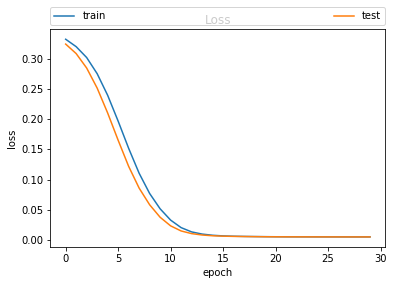

In [83]:
#InputWidth = x_train.shape[1]
K.clear_session()
timesteps = 1
inputdimension = 200
inp = Input(shape =(timesteps,inputdimension),name = 'inp')
# Conv2d - number of filters, filter size, activation function - outputshape = (N-F)/stride+1
encoder = LSTM(100,name ='l1')(inp)
x = RepeatVector(timesteps,name = 'r1')(encoder)
decoder = LSTM(inputdimension,return_sequences=True,name = 'l2')(x)
ae = Model(inp,decoder)
print ae.summary()
ae.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
op = ae.fit(x_train_noisy, x_train, validation_data=(x_test_noisy, x_test), epochs=30, batch_size=256, verbose=2).history

# Save the model
ae.save_weights('aelstm.h5')
plt.plot(op['loss'],label ='train')
plt.plot(op['val_loss'],label ='test')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp (InputLayer)             (None, 1, 200)            0         
_________________________________________________________________
l1 (LSTM)                    (None, 100)               120400    
_________________________________________________________________
r1 (RepeatVector)            (None, 1, 100)            0         
_________________________________________________________________
l2new (LSTM)                 (None, 1, 200)            240800    
Total params: 361,200
Trainable params: 240,800
Non-trainable params: 120,400
_________________________________________________________________
None
Train on 700 samples, validate on 300 samples
Epoch 1/30
0s - loss: 0.3160 - mean_squared_error: 0.3160 - val_loss: 0.2824 - val_mean_squared_error: 0.2824
Epoch 2/30
0s - loss: 0.2680 - mean_squared_error: 0.2680 - val_loss: 0.2358 - val_mean_squared_error

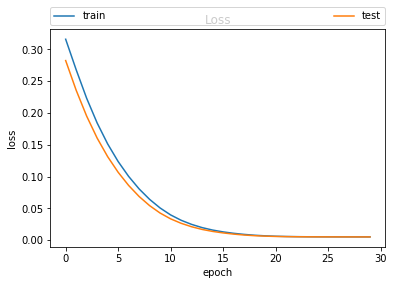

In [84]:
#K.clear_session()
timesteps = 1
inputdimension = 200
inp1 = Input(shape =(timesteps,inputdimension),name = 'inp')
# Conv2d - number of filters, filter size, activation function - outputshape = (N-F)/stride+1
encoder1 = LSTM(100,name ='l1',trainable = False)(inp1)
x1 = RepeatVector(timesteps,name = 'r1',trainable = False)(encoder1)
decoder1 = LSTM(inputdimension,return_sequences=True,name = 'l2new')(x1)
ae1 = Model(inp1,decoder1)

# Load the weights to the encoder and retrain the decoder. This gives a compression of the input.
ae1.load_weights('aelstm.h5',by_name=True)
print ae1.summary()
ae1.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
op = ae1.fit(x_train_noisy, x_train, validation_data=(x_test_noisy, x_test), epochs=30, batch_size=256, verbose=2).history

plt.plot(op['loss'],label ='train')
plt.plot(op['val_loss'],label ='test')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

## Type 2 - using only tensorflow

### Using only Feed forward Autoencoder - images

In [85]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()
# all the pixel values normalised between 0 and 1. Then we can use a classification method for reconstruction loss.
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
# reshaped to 784 (28x28), to be used with only fully connected neural nets
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print x_train.shape
print x_test.shape
x_train_noisy = x_train + 0.5 * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + 0.5 * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

(60000, 784)
(10000, 784)


In [86]:
K.clear_session()
inputs = tf.placeholder(tf.float32, shape=(None, x_train.shape[1]))
OutWidth = x_train.shape[1]
out = tf.placeholder(tf.float32, shape=(None, x_train.shape[1]))
def buildmodel(inp):
    e1 = tl.fully_connected(inp, 128, activation_fn=tf.nn.relu)
    e2 = tl.fully_connected(e1, 64, activation_fn=tf.nn.relu)
    e3 = tl.fully_connected(e2, 32, activation_fn=tf.nn.relu)
    e3 = tl.fully_connected(e3, 32, activation_fn=tf.nn.relu)
    d1 = tl.fully_connected(e3, 64, activation_fn=tf.nn.relu)
    d2 = tl.fully_connected(d1, 128, activation_fn=tf.nn.relu)
    d3 = tl.fully_connected(d2, OutWidth)
    d4 = tf.sigmoid(d3)
    return d3,d4

logits,output = buildmodel(inputs)
loss = tf.sqrt(tf.reduce_mean(tf.square(logits - inputs)))
#loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=out))
#loss = -tf.reduce_sum(inputs * tf.log(logits))

train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)
init = tf.global_variables_initializer()

loss 0.3437042
loss 0.28125057
loss 0.27460828
loss 0.27245852
loss 0.27054602
(10000, 784)


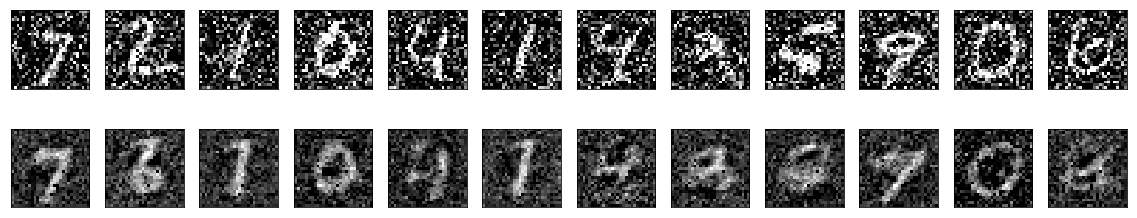

In [87]:
epoch = 100
batch_size = 1028
with tf.Session() as sess:
    sess.run(init)
    for e in range(epoch):
        total_batch = int(x_train.shape[0]/batch_size)
        for batch in range(total_batch):
            _, loss_val = sess.run([train_op, loss],feed_dict={inputs:x_train_noisy[batch:batch+batch_size],out:x_train[batch:batch+batch_size]})
        if(e%20==0):
            print "loss",np.mean(loss_val)
    predictions = output.eval(feed_dict={inputs: x_test_noisy})
    print predictions.shape
    #reconstructed_image = model.predict(x_test)
    import matplotlib.pyplot as plt
    n = 12  # Number of digits to display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test_noisy[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(predictions[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

### Anti Autoencoder - Swap the pixel bits black and white so that the output image is as dissimilar as possible. - We swap the pixels of the noisy data and then train on original data to predict the swapped noisy image.

In [88]:
x_train_noisy_swapped = (1-copy.deepcopy(x_train_noisy))
x_test_noisy_swapped = (1-copy.deepcopy(x_test_noisy))

In [94]:
K.clear_session()
inputs = tf.placeholder(tf.float32, shape=(None, x_train.shape[1]))
OutWidth = x_train.shape[1]
out = tf.placeholder(tf.float32, shape=(None, x_train.shape[1]))
def buildmodel(inp):
    e1 = tl.fully_connected(inp, 128, activation_fn=tf.nn.relu)
    e2 = tl.fully_connected(e1, 64, activation_fn=tf.nn.relu)
    e3 = tl.fully_connected(e2, 32, activation_fn=tf.nn.relu)
    e3 = tl.fully_connected(e3, 32, activation_fn=tf.nn.relu)
    d1 = tl.fully_connected(e3, 64, activation_fn=tf.nn.relu)
    d2 = tl.fully_connected(d1, 128, activation_fn=tf.nn.relu)
    d3 = tl.fully_connected(d2, OutWidth)
    d4 = tf.sigmoid(d3)
    return d3,d4

logits,output = buildmodel(inputs)
#loss = tf.sqrt(tf.reduce_mean(tf.square(logits - inputs)))
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=out))
#loss = -tf.reduce_sum(inputs * tf.log(logits))

train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)
init = tf.global_variables_initializer()

loss 0.5942926
loss 0.53782624
loss 0.5273913
loss 0.52190506
loss 0.51929396
(10000, 784)


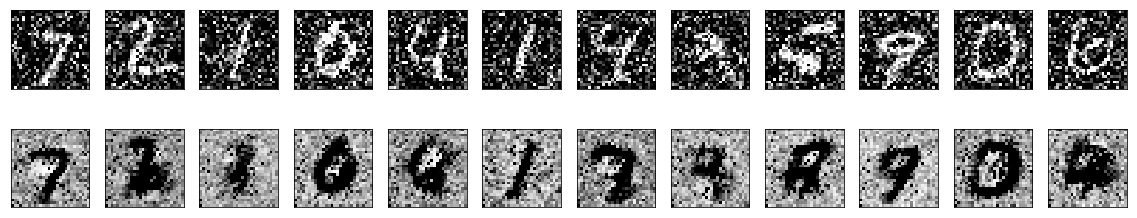

In [95]:
epoch = 100
batch_size = 2000
with tf.Session() as sess:
    sess.run(init)
    for e in range(epoch):
        total_batch = int(x_train.shape[0]/batch_size)
        for batch in range(total_batch):
            _, loss_val = sess.run([train_op, loss],feed_dict={inputs:x_train_noisy[batch:batch+batch_size],out:x_train_noisy_swapped[batch:batch+batch_size]})
        if(e%20==0):
            print "loss",np.mean(loss_val)
    predictions = output.eval(feed_dict={inputs: x_test_noisy})
    print predictions.shape
    #reconstructed_image = model.predict(x_test)
    import matplotlib.pyplot as plt
    n = 12  # Number of digits to display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test_noisy[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(predictions[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

### Everybody Freeze

#### Train a full AE, save the model. 

In [96]:
K.clear_session()
inputs = tf.placeholder(tf.float32, shape=(None, x_train.shape[1]))
OutWidth = x_train.shape[1]
out = tf.placeholder(tf.float32, shape=(None, x_train.shape[1]))
#def buildmodel(inp):
with tf.variable_scope('encoder'):
    e1 = tl.fully_connected(inputs, 128, activation_fn=tf.nn.relu,scope = 'e1')
    e2 = tl.fully_connected(e1, 64, activation_fn=tf.nn.relu,scope = 'e2')
    e3 = tl.fully_connected(e2, 32, activation_fn=tf.nn.relu,scope = 'e3')
    e3 = tl.fully_connected(e3, 32, activation_fn=tf.nn.relu,scope = 'e4')
with tf.variable_scope('decoder'):
    d1 = tl.fully_connected(e3, 64, activation_fn=tf.nn.relu,scope = 'd1')
    d2 = tl.fully_connected(d1, 128, activation_fn=tf.nn.relu,scope = 'd2')
    logits = tl.fully_connected(d2, OutWidth,scope = 'd3')
    output = tf.sigmoid(logits)


#logits,output = buildmodel(inputs)
loss = tf.sqrt(tf.reduce_mean(tf.square(logits - inputs)))
#loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=out))
#loss = -tf.reduce_sum(inputs * tf.log(logits))
train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)
init = tf.global_variables_initializer()

loss 0.33829272
loss 0.29792824
loss 0.2912569
loss 0.28787598
loss 0.2861282
(10000, 784)


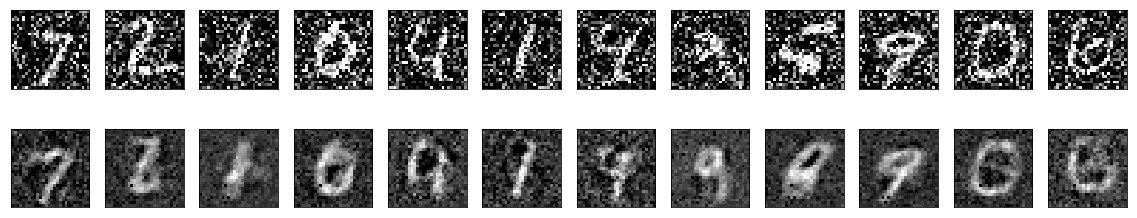

In [97]:
epoch = 100
batch_size = 2000
with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(init)
    for e in range(epoch):
        total_batch = int(x_train.shape[0]/batch_size)
        for batch in range(total_batch):
            _, loss_val = sess.run([train_op, loss],feed_dict={inputs:x_train_noisy[batch:batch+batch_size],out:x_train[batch:batch+batch_size]})
        if(e%20==0):
            print "loss",np.mean(loss_val)
    predictions = output.eval(feed_dict={inputs: x_test_noisy})
    print predictions.shape
    #reconstructed_image = model.predict(x_test)
    import matplotlib.pyplot as plt
    n = 12  # Number of digits to display
    plt.figure(figsize=(20, 4))
    saver.save(sess, './ae_tensorflowonly.ckpt')
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test_noisy[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(predictions[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

####  Define another ae model, but to the optimiser only specify the scope of the variables that need to be trained - in this case decoder.  Then reload the saved model, which assigns the weights to the network, and train the model (this only trains the decoder)

In [98]:
K.clear_session()
inputs = tf.placeholder(tf.float32, shape=(None, x_train.shape[1]))
OutWidth = x_train.shape[1]
out = tf.placeholder(tf.float32, shape=(None, x_train.shape[1]))
#def buildmodel(inp):
with tf.variable_scope('encoder'):
    e1 = tl.fully_connected(inputs, 128, activation_fn=tf.nn.relu,scope = 'e1')
    e2 = tl.fully_connected(e1, 64, activation_fn=tf.nn.relu,scope = 'e2')
    e3 = tl.fully_connected(e2, 32, activation_fn=tf.nn.relu,scope = 'e3')
    e3 = tl.fully_connected(e3, 32, activation_fn=tf.nn.relu,scope = 'e4')
with tf.variable_scope('decoder'):
    d1 = tl.fully_connected(e3, 64, activation_fn=tf.nn.relu,scope = 'd1')
    d2 = tl.fully_connected(d1, 128, activation_fn=tf.nn.relu,scope = 'd2')
    logits = tl.fully_connected(d2, OutWidth,scope = 'd3')
    output = tf.sigmoid(logits)


#logits,output = buildmodel(inputs)
loss = tf.sqrt(tf.reduce_mean(tf.square(logits - inputs)))
#loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=out))
#loss = -tf.reduce_sum(inputs * tf.log(logits))

# Key for speicifying that only decoder needs to be trained using the scope.
OnlyDecoderToTrain = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                      "decoder")   
train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss,var_list = OnlyDecoderToTrain)
init = tf.global_variables_initializer()

INFO:tensorflow:Restoring parameters from ./ae_tensorflowonly.ckpt
loss 0.28497714
loss 0.284691
loss 0.284528
loss 0.28439924
loss 0.28425705
(10000, 784)


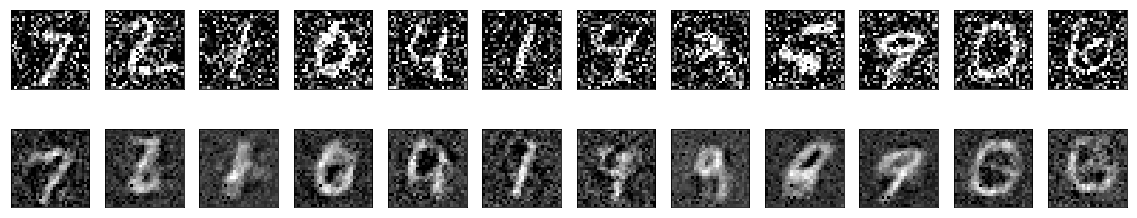

In [99]:
epoch = 100
batch_size = 2000
saver1 = tf.train.Saver()
nn_model = './ae_tensorflowonly.ckpt'
with tf.Session() as sess:
    sess.run(init)
    saver.restore(sess, nn_model)
    
    for e in range(epoch):
        total_batch = int(x_train.shape[0]/batch_size)
        for batch in range(total_batch):
            _, loss_val = sess.run([train_op, loss],feed_dict={inputs:x_train_noisy[batch:batch+batch_size],out:x_train[batch:batch+batch_size]})
        if(e%20==0):
            print "loss",np.mean(loss_val)
    predictions = output.eval(feed_dict={inputs: x_test_noisy})
    print predictions.shape
    #reconstructed_image = model.predict(x_test)
    import matplotlib.pyplot as plt
    n = 12  # Number of digits to display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test_noisy[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(predictions[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

#### Due to time and hardware constraints, CNN and LSTM have not been implemented. But it is very similar to the above implementation with the only difference in the input shapes and the layer definition.